In [1]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
import os
repo_path = Path.cwd()/'drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det'
os.chdir(str(repo_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !cp -r /content/drive/MyDrive/calcification-detection-project/calcification_detecion/new_data_rois/data_rois.zip /home/
# !unzip /home/data_rois.zip -d /home
# !mv /home/home/vzalevskyi/projects/data_rois /home/data_rois
# !rm -r /home/home

In [14]:
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

from deep_learning.dataset.dataset import INBreast_Dataset_pytorch

import copy
import torch
import time
import random
import pickle
from general_utils.plots import simple_im_show, simple_im_show2
from collections import Counter

from metrics.metrics import froc_curve
from metrics.metrics_utils import get_froc_df_of_img, get_froc_df_of_many_imgs_features, get_tp_fp_fn_center_patch_criteria

from deep_learning.dataset.dataset import ImgCropsDataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from torch.optim import lr_scheduler
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import pandas as pd

from database.dataset import INBreast_Dataset
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from deep_learning.models.base_classifier import CNNClasssifier
from deep_learning.models.detect_based_detector import DetectionBasedDetector
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from general_utils.plots import plot_froc
from general_utils.utils import get_center_bboxes
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        

def get_detection_model(num_classes):

    # LOAD OUR BEST RESNET
    # exp_path / f'{cfg["experiment_name"]}.pt'
    best_model_path = '/content/drive/MyDrive/calcification-detection-project/calcification_detecion/data/deepl_runs/resnet50_05/resnet50_05.pt'
    chkpt_path = '/content/drive/MyDrive/calcification-detection-project/calcification_detecion/data/deepl_runs/resnet50_05/resnet50_05_chkpt.pt'
    # exp_path / f'{cfg["experiment_name"]}_chkpt.pt'
    resnet50_model = CNNClasssifier(backbone='resnet50', fc_dims=None).model
    # load best model weights before returning
    # best_model = torch.load(best_model_path)
    # resnet50_model.load_state_dict(best_model['model_state_dict'])

    # resnet50_model.fc = Identity()

    modules = list(resnet50_model.children())[:-2]      # delete the last fc layer.
    resnet50_model_backbone = nn.Sequential(*modules)

    

    backbone = resnet50_model_backbone#.features
    backbone.out_channels = 2048#?1280

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((16, 32),),
                                    aspect_ratios=((1.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                    num_classes=num_classes,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)

    return model


In [5]:
datapath = Path('/content/drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det/data/INbreast Release 1.0')

In [6]:
dataset_arguments = {
    'extract_patches': False,
    'delete_previous': False,
    'extract_patches_method': 'all',
    'patch_size': 224,
    'stride': 100,
    'min_breast_fraction_roi': 0.7,
    'n_jobs': -1,
    'cropped_imgs': True,
    'ignore_diameter_px': 15,
    'neg_to_pos_ratio': None,
    'balancing_seed': 0,
    'normalization': 'min_max',
    'get_lesion_bboxes': True,
    'for_detection_net': True,
    'patch_images_path': Path( '/home/data_rois/'), # FOR GDRIVE '/home/data_rois/' '/home/vzalevskyi/projects/vlads_datarois/data_rois/'

    # ONLY FOR COLAB
    'imgpath':datapath/'AllMasks',
    'mask_path': datapath/'AllMasks',
    'dfpath':datapath
}

image_datasets = {
    'train': INBreast_Dataset_pytorch(
        partitions=['train'],
        **dataset_arguments
    ),
    'val': INBreast_Dataset_pytorch(
        partitions=['validation'],

        **dataset_arguments
    ),
    
}

/content/drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det/deep_learning/dataset/dataset.py:50: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  return_lesions_mask=get_lesion_bboxes, max_lesion_diam_mm=None, use_muscle_mask=False


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [8]:
model = get_detection_model(2)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/calcification-detection-project/models/fatserRCNN_resnet50_16patch.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

Plotting some results

In [9]:
# for i in range(3):

#     timage, ttarget = image_datasets['val'][i]
#     with torch.no_grad():
#         pred_target = model([timage.to(device)])[0]


#     result = draw_bounding_boxes((255*timage).to(torch.uint8), ttarget['boxes'], colors=['blue']*len(ttarget['boxes']),  width=1)
#     show(result)
#     result = draw_bounding_boxes((255*timage).to(torch.uint8), pred_target['boxes'], colors=['red']*len(pred_target['boxes']),  width=1)
#     show(result)

#     print(ttarget['boxes'])
#     print(pred_target['boxes'])
    
#     plt.show()

```AttributeError: 'NoneType' object has no attribute 'min'``` might indicate that you dont have the patches in the path provided to the database classes at `patch_images_path`

In [10]:
full_imgs_db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions=['validation'],
    lesion_types=['calcification', 'cluster'],
    cropped_imgs=True,
    keep_just_images_of_lesion_type=False,
    use_muscle_mask=False,
    ignore_diameter_px=15
)

In [30]:
det = DetectionBasedDetector(model, 224, 200, None, 8, 14, device, True, iou_threshold=0.5)

In [31]:
tps = []
fps = []
fns = []
ignoreds = []

R = 8 # radius of the patch (for now hardcoded since we've used 14x14 patches for training)


for idx in tqdm(range(len(full_imgs_db))):
    img = full_imgs_db[idx]['img']
    lesion_bboxes = full_imgs_db[idx]['lesion_bboxes']
    img_id = full_imgs_db[idx]['img_id']
    lesion_mask = full_imgs_db[idx]['lesion_mask']

    cands = det.detect(img)
    
    # convert predictions from [x1, x2, y1, y2] to (x_center, y_center, radius) convention
    # used by labelling
    cands_xyr = get_center_bboxes([((x[0], x[2]), (x[1], x[3])) for x in cands])
    
    # add radius column
    cands_xyr = np.append(cands_xyr, R*np.ones((len(cands_xyr), 1)), axis=1)

    # add score column
    cands_xyr = np.append(cands_xyr, cands[:,4].reshape(-1, 1), axis=1)

    tp, fp, fn, ignored = get_tp_fp_fn_center_patch_criteria(cands_xyr, lesion_mask, None, 14, True, scores_passed=True)
    
    tp['img_id'] = img_id
    fp['img_id'] = img_id
    fn['img_id'] = img_id
    ignored['img_id'] = img_id
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    ignoreds.append(ignored)

100%|██████████| 20/20 [04:33<00:00, 13.66s/it]


In [32]:
test_features = pd.concat(tps + fps)
fns_df = pd.concat(fns)
ignoreds_df = pd.concat(ignoreds)

In [33]:
test_features['candidate_coordinates'] = [[r['x'] , r['y'] , r['radius']] for idx, r in test_features.iterrows()]
test_features['label'] = test_features.label == 'TP'
test_features.head()

,x,y,radius,score,label,repeted_idxs,matching_gt,img_id,candidate_coordinates
0,984.0,2654.0,8.0,0.999161,True,0.0,2,20587294,"[984.0, 2654.0, 8.0]"
1,1513.0,1551.0,8.0,0.998100,True,1.0,1,20587294,"[1513.0, 1551.0, 8.0]"
0,789.0,2008.0,8.0,0.994779,True,0.0,2,20587320,"[789.0, 2008.0, 8.0]"
1,537.0,224.0,8.0,0.992854,True,1.0,4,20587320,"[537.0, 224.0, 8.0]"
2,537.0,224.0,8.0,0.992854,True,1.0,5,20587320,"[537.0, 224.0, 8.0]"


In [34]:
normal_imgs_ids = full_imgs_db.get_normal_imgs_ids()


froc_df_1st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    fns_df,
    test_features.score.values,
    normal_imgs_ids
)

sens1, avgs_fp_per_image1, _ = froc_curve(froc_df_1st, non_max_supression=True, cut_on_50fpi=True)


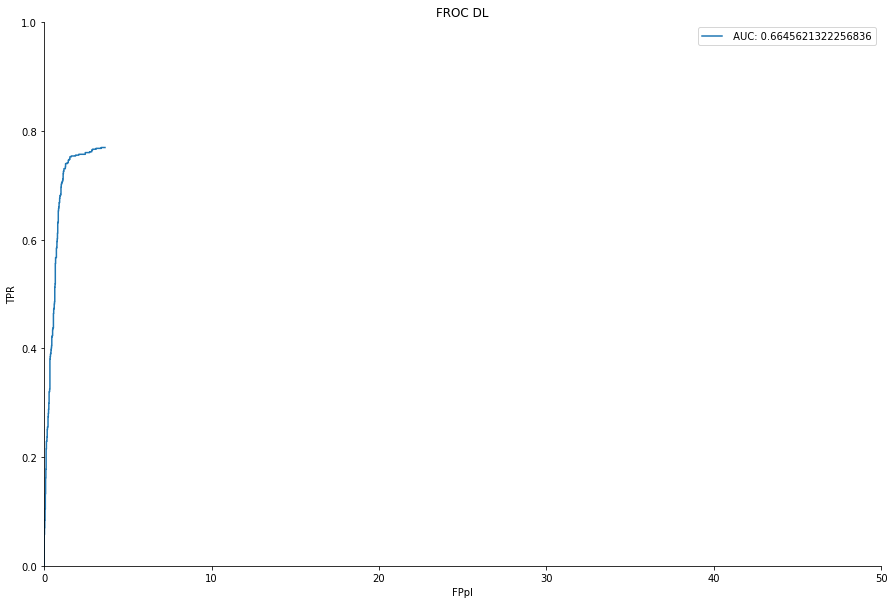

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
plot_froc(avgs_fp_per_image1, sens1, title='FROC DL', cut_on_50fpi=True, ax=axs)

